<center>
<h1><br/></h1>
<h1>INF581 lab9: VAEs and diffusion models</h1>
<br>
</center>

The goal of this notebook is to present the basics of variational auto-encoders (VAEs) and diffusion models, on some toy datasets so that training is not too long.


## Name your work

Replace the values in the following dictionary `info`. Your Email must match your class email address. Your Alias will be shown on the public leaderboard (to identify yourself).

In [ ]:
info = {
    "Email": "firstname.lastname@polytechnique.edu",
    "Alias": "Anonymous",  # (change this in case you want to identify yourself on the leaderboard)
}

<br>
<h2>Part 1: VAE for MNIST digits generation</h2>
<br>


The first part deals with variational auto-encoder (VAE). It is based on code from a <a href="https://dataflowr.github.io/website/">course of Marc Lelarge</a>, which itself borrows from existing classical implementations of VAEs in PyTorch that can be found [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65).



We will use MNIST dataset and a basic VAE architecture.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size))
    except:
        out, _, _ = model(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, z_dim=2, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            z = torch.randn(n*n_classes, z_dim).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            concat_input = torch.cat([z, y_onehot], 1)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out, n).cpu()
    show(out_grid)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Brief reminder on variational autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

There are various examples of VAE in PyTorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

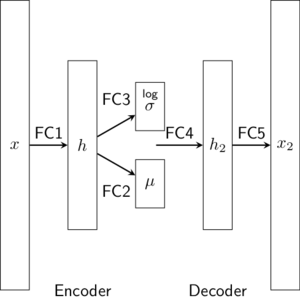

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy. The code below is still from the PyTorch tutorial (with minor modifications to avoid warnings!).

In [ ]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

In [ ]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

In [ ]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. The rest of this task is to explore one solution (a conditional VAE (CVAE)) to generates zeroes, ones, twos and so on.

# <font color="red">Task</font>: implement a conditional VAE

Implement a conditional VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that the encoder is now conditioned to two variables X and c: $q_{\theta}(z|X,c)$ while the decoder is conditioned to the variables z ad c: $p_{\theta}(X|z,c)$. Now, the real latent variable is distributed under $p(z|c)$.

The conditional VAE was proposed by [(Sohn et al., 2015)](https://papers.nips.cc/paper/2015/hash/8d55a249e6baa5c06772297520da2051-Abstract.html) and is explained in the tutorial [(Doersch, 2016)](https://arxiv.org/abs/1606.05908).

<font color="red">Task</font>: Implement a class CVAE and its training by making minimal changes to the VAE code above. You can use the function plot_conditional_generation above to test your code. For instance, plot_conditional_generation(cvae, fix_number=3) should plot 8 images in the same row with independent generations of the number 3.

Your are free to modify the network structure and the training parameters as long as training remains reasonable and you should try to obtain decent digits generation. Besides this, make minimal changes to the code above.

Please use the code above to load the data, it checks if the data is not already present before downloading it. For ecological reasons, we will make sure to run your code in a folder that already contains the data.  

Note: you will need to add "n_classes = 10" as this variables is used in the function "plot_conditional_generation".


In [ ]:
n_classes = 10

class CVAE(nn.Module):
    # TODO: implement the class CVAE by implementing the methods
    # __init__, encode, reparameterize, decode, forward
    # 

# TODO: build model
# 
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)


In [ ]:
# TODO: train the model
# 

The following commands should then print the results generated.

In [ ]:
#print a grid with each digit in a row (8 images of each digit per row)
plot_conditional_generation(cvae, n=8, z_dim=4, fix_number=None)
#print a line with just a row of digit 2 (8 images)
plot_conditional_generation(cvae, n=8, z_dim=4, fix_number=2)


<br>
<h2>Part 2: A simple diffusion model for the Swiss roll data</h2>
<br>


The second part presents a diffusion model. We implement the Denoising Diffusion Probabilistic model (DDPM) by <a href="https://arxiv.org/abs/2006.11239">Ho et al., 2020</a>.

We use the Swiss roll dataset and purposely use a very simple model instead of a Unet to minimize the training time.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

## Model

The model (that predicts noise) is given in the following cell. It is a very simple model with just two hiden layers, conditioned on time.

In [ ]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, in_dim, h_dim, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(in_dim, h_dim, n_steps)
        self.lin2 = ConditionalLinear(h_dim, h_dim, n_steps)
        self.lin3 = ConditionalLinear(h_dim, h_dim, n_steps)
        self.lin4 = nn.Linear(h_dim, in_dim)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)




## Variance schedule

In [ ]:
def linear_beta_schedule(timesteps, start_scale=0.0001, end_scale=0.02):
    # TODO: implement the linear beta schedule
    # should return a linearly spaced tensor between start_scale to end_scale
    # 


## Gaussian diffusion model

This is the part that content all the details of the diffusion model.

<font color="red">Task:</font> you will need to complete all incomplete functions, although not all are needed at first to test the noising

In [ ]:

class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
    ):

        self.timesteps = timesteps

        # betas: variance at time t
        betas = linear_beta_schedule(timesteps)
        self.betas = betas

        # alphas: 1-betas and cumulative products
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # computation of various useful parameters for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # computation of mean and variance for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        # extracts the param at a given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        # forward diffusion: samples x_t conditioned on x_0
        # Note: (20.8) in [Bishop, 2024]
        if noise is None:
            noise = torch.randn_like(x_start)

        # TODO: implement this function
        # Hint: use self.sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod computed above
        #       and the _extract method to extract their value at t
        # 

    def q_posterior_mean_variance(self, x_start, x_t, t):
        # Computes the mean and variance of the posterior distribution: q(x_{t-1} | x_t, x_0)
        # Note: (20.16), (20.17) in [Bishop, 2024]
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )

        # TODO: complete for the variance:
        # Hint: use the precompute attributes self.posterior_variance and self.posterior_log_variance_clipped
        # posterior_variance = ...
        # posterior_log_variance_clipped = ...
        # 

        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t, t, noise):
        # Computes x_0 from x_t and the predicted noise: the reverse of q_sample
        # Note: (20.34) in [Bishop, 2024]

        # TODO: implement this function
        # 

    def p_mean_variance(self, model, x_t, t, clip_denoised=False):
        # Computes predicted mean and variance of p(x_{t-1} | x_t)
        # This function just applies q_posterior_mean_variance to the predicted noise

        # first get the predicted noise from the model and compute corresponding x_0

        # TODO: complete
        # pred_noise = ...
        # x_start = ...
        # 

        # clip the denoised x_0
        if clip_denoised:
            torch.clamp(x_start, min=-1., max=1.)
        #return the result from q_posterior_mean_variance
        return self.q_posterior_mean_variance(x_start = x_start, x_t = x_t, t = t)

    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=False):
        # Computes one denoising step: sample x_{t-1} from x_t and pred_noise
        # first predict mean and variance
        # Note: uses the predicted variance rather than beta_t -- see Section 3.2 of Ho et al, 2020
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img


    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        # Generates data by reverse diffusion (generates a batch using the dimension in shape)
        batch_size = shape[0]
        device = next(model.parameters()).device

        # start with pure noise
        data_t = torch.randn(shape, device=device) # the initial data (noise) x_T
        data = [data_t] # initialize the list that will contain [x_t, t = T..0]

        # TODO: write a loop that generates the list [x_t, t = T..0]
        # 

        return data

    def training_loss(self, model, x_start, t):
        # Computes the training loss
        # first generate random noise

        noise = torch.randn_like(x_start)
        # TODO: complete this function
        # Hint:
        # - compute the noised data from x_start and noise
        # - use model to predict the noise from this noised data
        # - then compare the predicted noise to the initial variable noise
        # 



## Generating the data set

Nothing to do here other than execute.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll

batch_size = 128
nb_batch = 1000
data_batch = []
for i_batch in range(nb_batch):
    x, _= make_swiss_roll(batch_size, noise=0.5)
    x = x[:, [0, 2]] / 10.0
    data_batch += [torch.tensor(x).float()]


data = torch.Tensor(nb_batch*batch_size, 2)
torch.cat(data_batch, out=data)

plt.figure(figsize=(8, 8))
plt.scatter(*data.T, alpha=0.5, color='red', edgecolor='white', s=40);

## Test the noising process

<font color="red">Task</font>: implement the function q_sample in the GaussianDiffusion class and run the code below.

You should get a graph that looks like this:
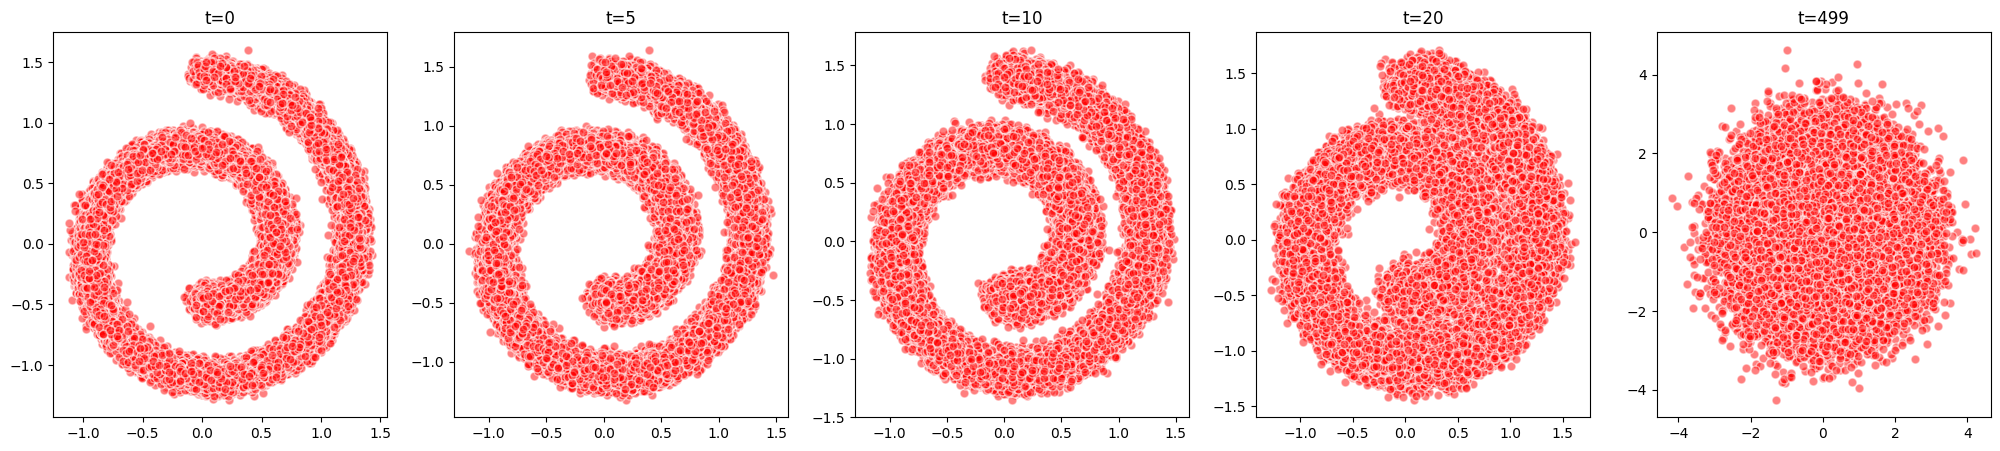


In [ ]:
gaussian_diffusion = GaussianDiffusion(timesteps=1000)

plt.figure(figsize=(25, 5))
for idx, t in enumerate([0, 5, 10, 20, 499]):
    data_noisy = torch.zeros_like(data)
    for i in range(nb_batch*batch_size):
        x_start = data[i]
        x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
        data_noisy[i] = x_noisy
    plt.subplot(1, 5, 1 + idx)
    plt.scatter(*data_noisy.T, alpha=0.5, color='red', edgecolor='white', s=40);
    plt.title(f"t={t}")


## Model and gaussian diffusion definition

Nothing to do here, just execute this cell that instantiates the model and diffusion process.

In [ ]:
# define model and diffusion
timesteps = 1000
in_dim = 2
h_dim = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConditionalModel(in_dim, h_dim, timesteps)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training

<font color="red">Task</font>: Complete all functions from the GaussianDiffusion class. Then complete the training loop below and run the cell.

This will train the model and draw every 50 epochs a graph that shows how well the model has learned to generate.

Warning: it takes some time (typically a minute per 20 epochs on google colab without GPU, so 10 min for 200 epochs with the model provided).

In [ ]:
import random


epochs = 200
for epoch in range(1,epochs+1):
    random.shuffle(data_batch)
    for step, batch in enumerate(data_batch):
      optimizer.zero_grad()

      # TODO: complete the training implementation
      # Hint:
      # - first draw randomly t (one per batch item)
      # - then compute the loss for the batch at those drawn times
      # 

      loss.backward()
      optimizer.step()

      if epoch % 10 == 0 and step == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()} ")

      if epoch % 50 == 0 and step == 0:
        data_generated = gaussian_diffusion.p_sample_loop(model, (1000, 2))

        plt.figure(figsize=(25, 5))
        for idx, t in enumerate([0, 400, 800, 999, 1000]):
          plt.subplot(1, 5, 1 + idx)
          plt.scatter(*data_generated[t].T, alpha=0.5, color='red', edgecolor='white', s=40);
          plt.title(f"Epoch={epoch}, t={t}")
          plt.show


## Generation

You can now generate data with the trained model.

In [ ]:
data_generated = gaussian_diffusion.p_sample_loop(model, (1000, 2))

plt.figure(figsize=(25, 5))
for idx, t in enumerate([0, 400, 800, 999, 1000]):
    plt.subplot(1, 5, 1 + idx)
    plt.scatter(*data_generated[t].T, alpha=0.5, color='red', edgecolor='white', s=40);
    plt.title(f"t={t}")
